# Cross-Lingual Transferability of Voice Analysis Models: a Parkinson's Disease Case Study

## Preliminaries

### Imports

In [1]:
from typing import Tuple, List, Dict, Union, Optional

In [2]:
import os
from ast import literal_eval
import datetime

In [205]:
import numpy as np
import pandas as pd
import librosa

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

### Constants

In [53]:
EN_DATA_DIR: str = '../resources/data/preprocessed/en/'
EN_METADATA_FILE: str = '../resources/data/preprocessed/en/metadata.csv'
HI_DATA_DIR: str = '../resources/data/preprocessed/hi/'
HI_METADATA_FILE: str = '../resources/data/preprocessed/hi/metadata.csv'

In [54]:
EN_TO_HI_EXPERIMENTS_DIR: str = ''
HI_TO_EN_EXPERIMENTS_DIR: str = '/Users/vincenzoscotti_polimi/Desktop/'

In [55]:
OUT_DIR_PATH: str = '../experiments/results'
if not os.path.exists(OUT_DIR_PATH):
    os.mkdir(OUT_DIR_PATH)

In [56]:
LABEL_MAPPING: Dict[str, str] = {
    'healthy': 'Healthy conditions',
    'unhealthy': 'Parkinson\'s disease'
}
FEATURES_MAPPING: Dict[str, str] = {
    'spectral': 'Acoustic and Spectral',
    'vggish': 'VGGish',
    'soundnet': 'SoundNet',
    'wav2vec': 'Wav2Vec 2.0'
}
POOLING_MAPPING: Dict[str, str] = {
    'avg': 'Avg. pooling',
    'max': 'Max pooling',
    'flatten': 'Flattening'
}
ADAPTATION_MAPPING: Dict[bool, str] = {
    False: 'None',
    True: 'CORrelation ALignment (CORAL)'
}
DATA_MAPPING: Dict[str, str] = {
    'src': 'Source data (test split)',
    'tgt': 'Target data'
}
METRICS_MAPPING: Dict[str, str] = {
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'fscore': '$F_1$-score',
    'specificity': 'Specificity',
    'roc_auc': 'ROC AUC',
    'support': 'Support',
    'fpr': 'False positives rate',
    'tpr': 'True postives rate',
    'roc_thresholds': 'Threshold (from ROC curve)',
    'precisions': 'Precision score',
    'recalls': 'Recall score',
    'pr_rc_thresholds': 'Threshold (from precision-recall curve)',
    'confusion_matrix': 'Confusion matrix'
}

In [57]:
METRICS = ['Accuracy', 'Precision', 'Recall', '$F_1$-score', 'Specificity', 'ROC AUC']
ROC = ['False positives rate', 'True postives rate', 'Threshold (from ROC curve)']
PRC_REC = ['Precision score', 'Recall score', 'Threshold (from precision-recall curve)']
CONF_MAT = ['Confusion matrix']

In [58]:
DF_COLUMNS: List[str] = ['Input features', 'Pooling approach', 'Domain adaptation', 'Data set', 'Metric', 'Value']

### Utility function(s)

In [59]:
def get_duration(path: str) -> Optional[float]:
    if os.path.exists(path):
        return librosa.get_duration(filename=path)
    else:
        return None

In [60]:
def convert_series(raw_series: pd.Series) -> Tuple[
    str, str, str, str, str, Union[float, int, List[float], List[List[int]]]
]:
    feature: str = FEATURES_MAPPING[raw_series['feature']]
    pooling: str = POOLING_MAPPING[raw_series['pooling']]
    adaptation: str = ADAPTATION_MAPPING[raw_series['adaptation']]
    data: str = DATA_MAPPING[raw_series['data_set']]
    metric: str = METRICS_MAPPING[raw_series['metric']]
    value = literal_eval(raw_series['value'])
    
    return feature, pooling, adaptation, data, metric, value

In [61]:
def convert_results_df(raw_df: pd.DataFrame) -> pd.DataFrame:
    df: pd.DataFrame = pd.DataFrame(
        [convert_series(row) for _, row in raw_df.iterrows()], columns=DF_COLUMNS
    )

    return df

## Data

Load data

In [13]:
df_en_metadata: pd.DataFrame = pd.read_csv(EN_METADATA_FILE, )
df_en_metadata['Language'] = 'English'
df_en_metadata['Label'] = df_en_metadata.apply(lambda r: LABEL_MAPPING[r['label']], axis=1)

df_en_metadata.sample(10)

,file_name,label,original_file_name,start_time,end_time,Language,Label
250,ReadText_PD_ID27_pd_4_1_1_004.wav,unhealthy,ReadText/PD/ID27_pd_4_1_1.wav,00:01:08.000,00:01:22.000,English,Parkinson's disease
314,SpontaneousDialogue_HC_ID09_hc_0_0_0_000.wav,healthy,SpontaneousDialogue/HC/ID09_hc_0_0_0.wav,00:00:28.000,00:00:40.000,English,Healthy conditions
243,ReadText_PD_ID24_pd_2_0_0_004.wav,unhealthy,ReadText/PD/ID24_pd_2_0_0.wav,00:01:33.000,00:01:45.000,English,Parkinson's disease
121,ReadText_HC_ID25_hc_0_0_0_002.wav,healthy,ReadText/HC/ID25_hc_0_0_0.wav,00:01:05.000,00:01:19.000,English,Healthy conditions
183,ReadText_PD_ID04_pd_2_0_1_006.wav,unhealthy,ReadText/PD/ID04_pd_2_0_1.wav,00:01:44.000,00:01:59.000,English,Parkinson's disease
17,ReadText_HC_ID01_hc_0_0_0_007.wav,healthy,ReadText/HC/ID01_hc_0_0_0.wav,00:02:02.000,00:02:11.000,English,Healthy conditions
182,ReadText_PD_ID04_pd_2_0_1_005.wav,unhealthy,ReadText/PD/ID04_pd_2_0_1.wav,00:01:32.000,00:01:44.000,English,Parkinson's disease
284,ReadText_PD_ID34_pd_2_0_0_004.wav,unhealthy,ReadText/PD/ID34_pd_2_0_0.wav,00:01:14.000,00:01:21.000,English,Parkinson's disease
153,ReadText_HC_ID31_hc_0_1_1_010.wav,healthy,ReadText/HC/ID31_hc_0_1_1.wav,00:03:00.000,00:03:10.000,English,Healthy conditions
14,ReadText_HC_ID01_hc_0_0_0_004.wav,healthy,ReadText/HC/ID01_hc_0_0_0.wav,00:00:54.000,00:01:07.000,English,Healthy conditions


In [14]:
df_hi_metadata: pd.DataFrame = pd.read_csv(HI_METADATA_FILE)
df_hi_metadata['Language'] = 'Hindi'
df_hi_metadata['Label'] = df_hi_metadata.apply(lambda r: LABEL_MAPPING[r['label']], axis=1)

df_hi_metadata.sample(10)

,file_name,label,original_file_name,start_time,end_time,Language,Label
31,AUD-20210713-WA0006_001.wav,unhealthy,AUD-20210713-WA0006.wav,00:00:11.000,00:00:21.000,Hindi,Parkinson's disease
147,hi_clips_common_voice_hi_34096324_000.wav,healthy,hi/clips/common_voice_hi_34096324.mp3,NaN,NaN,Hindi,Healthy conditions
94,hi_clips_common_voice_hi_33243596_000.wav,healthy,hi/clips/common_voice_hi_33243596.mp3,NaN,NaN,Hindi,Healthy conditions
8,AUD-20210527-WA0000_002.wav,unhealthy,AUD-20210527-WA0000.wav,00:00:27.000,00:00:35.000,Hindi,Parkinson's disease
48,PTT-20210524-WA0021_002.wav,unhealthy,PTT-20210524-WA0021.wav,00:00:47.000,00:00:54.000,Hindi,Parkinson's disease
114,hi_clips_common_voice_hi_33680985_000.wav,healthy,hi/clips/common_voice_hi_33680985.mp3,NaN,NaN,Hindi,Healthy conditions
199,hi_clips_common_voice_hi_34097648_000.wav,healthy,hi/clips/common_voice_hi_34097648.mp3,NaN,NaN,Hindi,Healthy conditions
32,AUD-20210713-WA0006_002.wav,unhealthy,AUD-20210713-WA0006.wav,00:00:25.000,00:00:38.000,Hindi,Parkinson's disease
195,hi_clips_common_voice_hi_34097601_000.wav,healthy,hi/clips/common_voice_hi_34097601.mp3,NaN,NaN,Hindi,Healthy conditions
111,hi_clips_common_voice_hi_33680982_000.wav,healthy,hi/clips/common_voice_hi_33680982.mp3,NaN,NaN,Hindi,Healthy conditions


In [15]:
df_metadata = pd.concat([df_en_metadata, df_hi_metadata]).reset_index()

df_metadata.sample(10)

,index,file_name,label,original_file_name,start_time,end_time,Language,Label
430,430,SpontaneousDialogue_PD_ID20_pd_3_0_1_002.wav,unhealthy,SpontaneousDialogue/PD/ID20_pd_3_0_1.wav,00:01:06.000,00:01:10.000,English,Parkinson's disease
676,211,hi_clips_common_voice_hi_34097775_000.wav,healthy,hi/clips/common_voice_hi_34097775.mp3,NaN,NaN,Hindi,Healthy conditions
97,97,ReadText_HC_ID21_hc_0_0_0_002.wav,healthy,ReadText/HC/ID21_hc_0_0_0.wav,00:00:53.000,00:01:02.000,English,Healthy conditions
186,186,ReadText_PD_ID06_pd_3_1_1_002.wav,unhealthy,ReadText/PD/ID06_pd_3_1_1.wav,00:01:03.000,00:01:15.000,English,Parkinson's disease
215,215,ReadText_PD_ID16_pd_2_0_0_006.wav,unhealthy,ReadText/PD/ID16_pd_2_0_0.wav,00:02:12.000,00:02:19.000,English,Parkinson's disease
585,120,hi_clips_common_voice_hi_33797544_000.wav,healthy,hi/clips/common_voice_hi_33797544.mp3,NaN,NaN,Hindi,Healthy conditions
655,190,hi_clips_common_voice_hi_34096950_000.wav,healthy,hi/clips/common_voice_hi_34096950.mp3,NaN,NaN,Hindi,Healthy conditions
565,100,hi_clips_common_voice_hi_33243617_000.wav,healthy,hi/clips/common_voice_hi_33243617.mp3,NaN,NaN,Hindi,Healthy conditions
104,104,ReadText_HC_ID22_hc_0_0_0_001.wav,healthy,ReadText/HC/ID22_hc_0_0_0.wav,00:00:45.000,00:00:54.000,English,Healthy conditions
243,243,ReadText_PD_ID24_pd_2_0_0_004.wav,unhealthy,ReadText/PD/ID24_pd_2_0_0.wav,00:01:33.000,00:01:45.000,English,Parkinson's disease


Distribution of duration (in seconds) of audio files

In [16]:
df_metadata['Duration [s]'] = df_metadata.apply(
    lambda r: get_duration(os.path.join(EN_DATA_DIR if r['Language'] == 'English' else HI_DATA_DIR, r['file_name'])), axis=1
)
df_metadata.sample(10)

,index,file_name,label,original_file_name,start_time,end_time,Language,Label,Duration [s]
661,196,hi_clips_common_voice_hi_34097640_000.wav,healthy,hi/clips/common_voice_hi_34097640.mp3,NaN,NaN,Hindi,Healthy conditions,3.617313
640,175,hi_clips_common_voice_hi_34096796_000.wav,healthy,hi/clips/common_voice_hi_34096796.mp3,NaN,NaN,Hindi,Healthy conditions,6.353313
486,21,AUD-20210628-WA0009_000.wav,unhealthy,AUD-20210628-WA0009.wav,00:00:00.000,00:00:10.000,Hindi,Parkinson's disease,10.026667
663,198,hi_clips_common_voice_hi_34097646_000.wav,healthy,hi/clips/common_voice_hi_34097646.mp3,NaN,NaN,Hindi,Healthy conditions,5.993313
213,213,ReadText_PD_ID16_pd_2_0_0_004.wav,unhealthy,ReadText/PD/ID16_pd_2_0_0.wav,00:01:47.000,00:01:55.000,English,Parkinson's disease,8.016667
55,55,ReadText_HC_ID11_hc_0_0_0_003.wav,healthy,ReadText/HC/ID11_hc_0_0_0.wav,00:01:14.000,00:01:23.000,English,Healthy conditions,9.007143
248,248,ReadText_PD_ID27_pd_4_1_1_002.wav,unhealthy,ReadText/PD/ID27_pd_4_1_1.wav,00:00:47.000,00:00:57.000,English,Parkinson's disease,9.997619
178,178,ReadText_PD_ID04_pd_2_0_1_001.wav,unhealthy,ReadText/PD/ID04_pd_2_0_1.wav,00:00:52.000,00:00:57.000,English,Parkinson's disease,5.014286
135,135,ReadText_HC_ID28_hc_0_0_0_000.wav,healthy,ReadText/HC/ID28_hc_0_0_0.wav,00:00:26.000,00:00:32.000,English,Healthy conditions,6.004762
82,82,ReadText_HC_ID15_hc_0_0_0_004.wav,healthy,ReadText/HC/ID15_hc_0_0_0.wav,00:01:31.000,00:01:44.000,English,Healthy conditions,13.000000


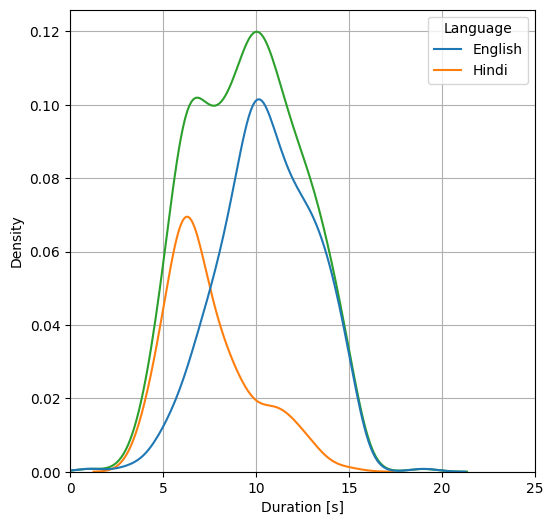

In [17]:
fig = plt.figure(figsize=(6, 6))

sns.kdeplot(data=df_metadata, x='Duration [s]', color='tab:green')
sns.kdeplot(data=df_metadata, x='Duration [s]', hue='Language' , color=['tab:red', 'tab:green'])
plt.xlabel('Duration [s]')
plt.xlim(0, 25)
plt.grid()

plt.show()

In [18]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration.pdf'))

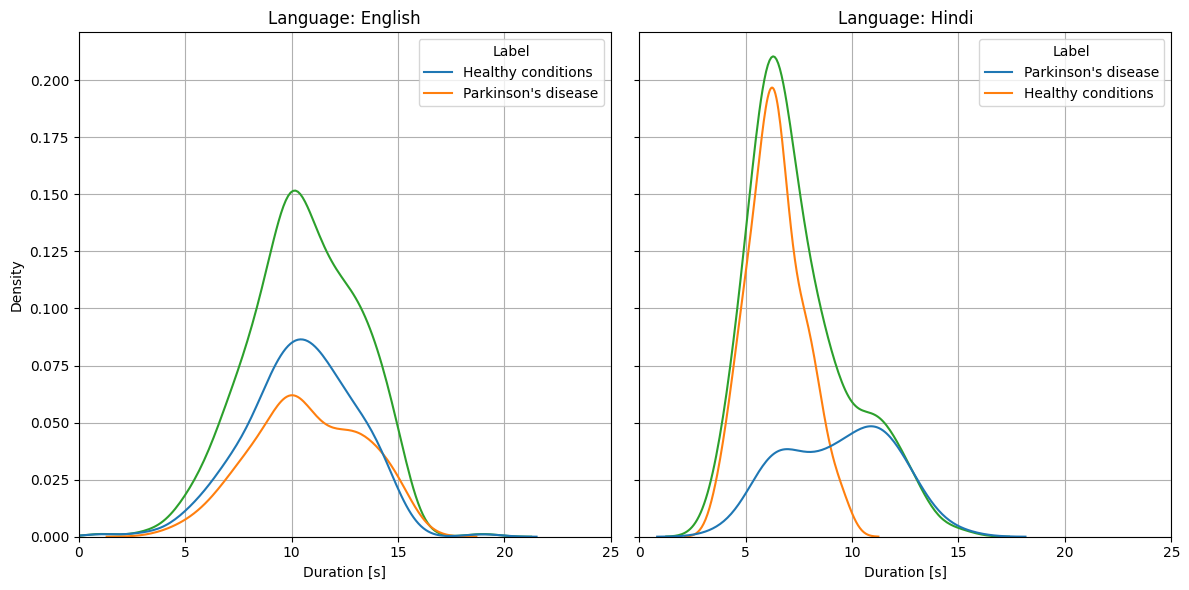

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True)

for i, (language) in enumerate(['English', 'Hindi']):
    sns.kdeplot(data=df_metadata[df_metadata['Language'] == language], x='Duration [s]', color='tab:green', ax=axes[i])
    sns.kdeplot(
        data=df_metadata[df_metadata['Language'] == language],
        x='Duration [s]',
        hue='Label',
        color=['tab:red', 'tab:blue'],
        ax=axes[i]
    )
    plt.xlabel('Duration [s]')
    axes[i].set_title(f'Language: {language}')
    axes[i].set_xlabel('Duration [s]')
    axes[i].grid()
    axes[i].set_xlim(0, 25)

plt.tight_layout()
plt.show()


In [20]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration_lang.pdf'))

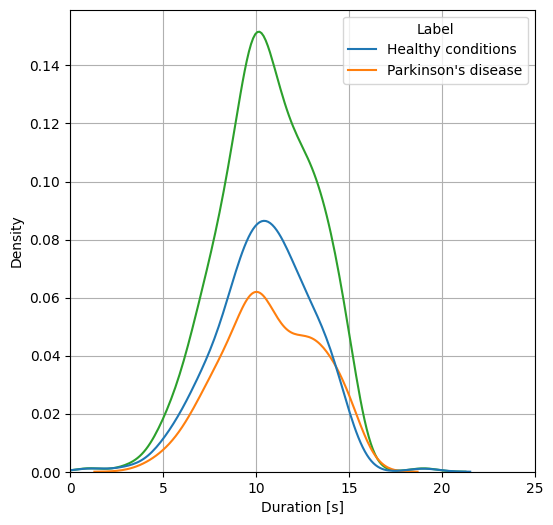

In [21]:
fig = plt.figure(figsize=(6, 6))

sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'English'], x='Duration [s]', color='tab:green')
sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'English'], x='Duration [s]', hue='Label' , color=['tab:red', 'tab:blue'])
plt.xlabel('Duration [s]')
plt.xlim(0, 25)
plt.grid()

plt.show()

In [22]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration_en.pdf'))

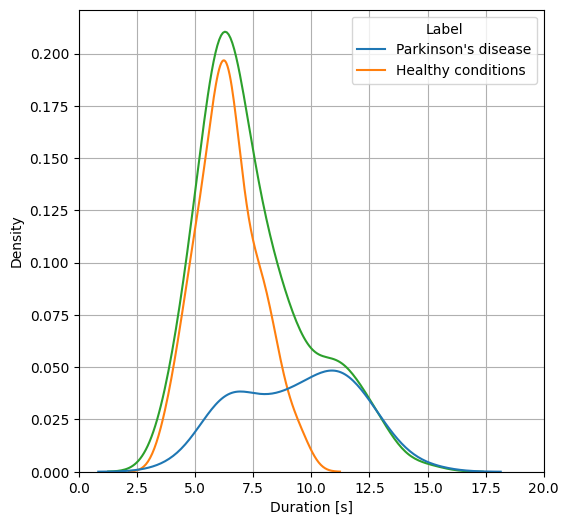

In [23]:
fig = plt.figure(figsize=(6, 6))

sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'Hindi'], x='Duration [s]', color='tab:green')
sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'Hindi'], x='Duration [s]', hue='Label' , color=['tab:red', 'tab:green'])
plt.xlabel('Duration [s]')
plt.xlim(0, 20)
plt.grid()

plt.show()

In [24]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration_hi.pdf'))

Cumulative durations

In [25]:
print(f"Total time [s]:                        {datetime.timedelta(seconds=df_metadata['Duration [s]'].sum())}")
print(f"Healthy patients time [s]:             {datetime.timedelta(seconds=df_metadata[df_metadata['Label'] == 'Healthy conditions']['Duration [s]'].sum())}")
print(f"Parkinson's disease patients time [s]: {datetime.timedelta(seconds=df_metadata[df_metadata['Label'] != 'Healthy conditions']['Duration [s]'].sum())}")

Total time [s]:                        1:49:17.437625
Healthy patients time [s]:             1:01:00.315054
Parkinson's disease patients time [s]: 0:48:17.122571


In [26]:
for language in ['English', 'Hindi']:
    print(language)
    print(f"Total time [s]:                        {datetime.timedelta(seconds=df_metadata[df_metadata['Language'] == language]['Duration [s]'].sum())}")
    print(f"Healthy patients time [s]:             {datetime.timedelta(seconds=df_metadata[(df_metadata['Label'] == 'Healthy conditions') & (df_metadata['Language'] == language)]['Duration [s]'].sum())}")
    print(f"Parkinson's disease patients time [s]: {datetime.timedelta(seconds=df_metadata[(df_metadata['Label'] != 'Healthy conditions') & (df_metadata['Language'] == language)]['Duration [s]'].sum())}")
    print('\n')

English
Total time [s]:                        1:21:03.083333
Healthy patients time [s]:             0:45:25.171429
Parkinson's disease patients time [s]: 0:35:37.911905


Hindi
Total time [s]:                        0:28:14.354292
Healthy patients time [s]:             0:15:35.143625
Parkinson's disease patients time [s]: 0:12:39.210667




## Results
Load DataFrames with results

In [62]:
df_en_to_hi: pd.DataFrame = pd.read_csv(os.path.join(EN_TO_HI_EXPERIMENTS_DIR, 'scores.csv'))
df_en_to_hi = convert_results_df(df_en_to_hi)

FileNotFoundError: [Errno 2] No such file or directory: 'scores.csv'

In [63]:
df_hi_to_en = pd.read_csv(os.path.join(HI_TO_EN_EXPERIMENTS_DIR, 'scores.csv'))
df_hi_to_en = convert_results_df(df_hi_to_en)
df_hi_to_en.sample(10)

,Input features,Pooling approach,Domain adaptation,Data set,Metric,Value
414,SoundNet,Max pooling,None,Target data,True postives rate,"[0.45869016794148376, 0.9637022574553731, 0.51..."
458,SoundNet,Flattening,None,Source data (test split),Precision score,"[0.15582086516272453, 0.8506588820902322, 0.92..."
346,SoundNet,Avg. pooling,None,Source data (test split),Precision score,"[0.8848222246437815, 0.7834082719272707, 0.552..."
546,Wav2Vec 2.0,Avg. pooling,CORrelation ALignment (CORAL),Target data,Accuracy,0.548358
105,Acoustic and Spectral,Max pooling,CORrelation ALignment (CORAL),Target data,False positives rate,"[0.6329563960025597, 0.5422956795475258, 0.023..."
48,Acoustic and Spectral,Avg. pooling,CORrelation ALignment (CORAL),Target data,ROC AUC,0.706497
655,Wav2Vec 2.0,Flattening,CORrelation ALignment (CORAL),Source data (test split),Recall score,"[0.7383739627305006, 0.6420015274944493, 0.250..."
439,SoundNet,Max pooling,CORrelation ALignment (CORAL),Target data,Specificity,0.846523
92,Acoustic and Spectral,Max pooling,CORrelation ALignment (CORAL),Source data (test split),True postives rate,"[0.23723039695199155, 0.3054860870331142, 0.67..."
4,Acoustic and Spectral,Avg. pooling,None,Source data (test split),Support,3


### Detection in English

### Transferring from English to Hindi

### Detection in Hindi

In [64]:
df = df_hi_to_en[
    (df_hi_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_hi_to_en['Data set'] == DATA_MAPPING['src']) & df['Metric'].isin(METRICS)
]
df

,Input features,Pooling approach,Domain adaptation,Data set,Metric,Value
0,Acoustic and Spectral,Avg. pooling,None,Source data (test split),Accuracy,0.856887
1,Acoustic and Spectral,Avg. pooling,None,Source data (test split),Precision,0.341036
2,Acoustic and Spectral,Avg. pooling,None,Source data (test split),Recall,0.128991
3,Acoustic and Spectral,Avg. pooling,None,Source data (test split),$F_1$-score,0.217337
5,Acoustic and Spectral,Avg. pooling,None,Source data (test split),Specificity,0.801216
...,...,...,...,...,...,...
617,Wav2Vec 2.0,Flattening,None,Source data (test split),Precision,0.496082
618,Wav2Vec 2.0,Flattening,None,Source data (test split),Recall,0.213659
619,Wav2Vec 2.0,Flattening,None,Source data (test split),$F_1$-score,0.427822
621,Wav2Vec 2.0,Flattening,None,Source data (test split),Specificity,0.04361


#### Metrics comparison

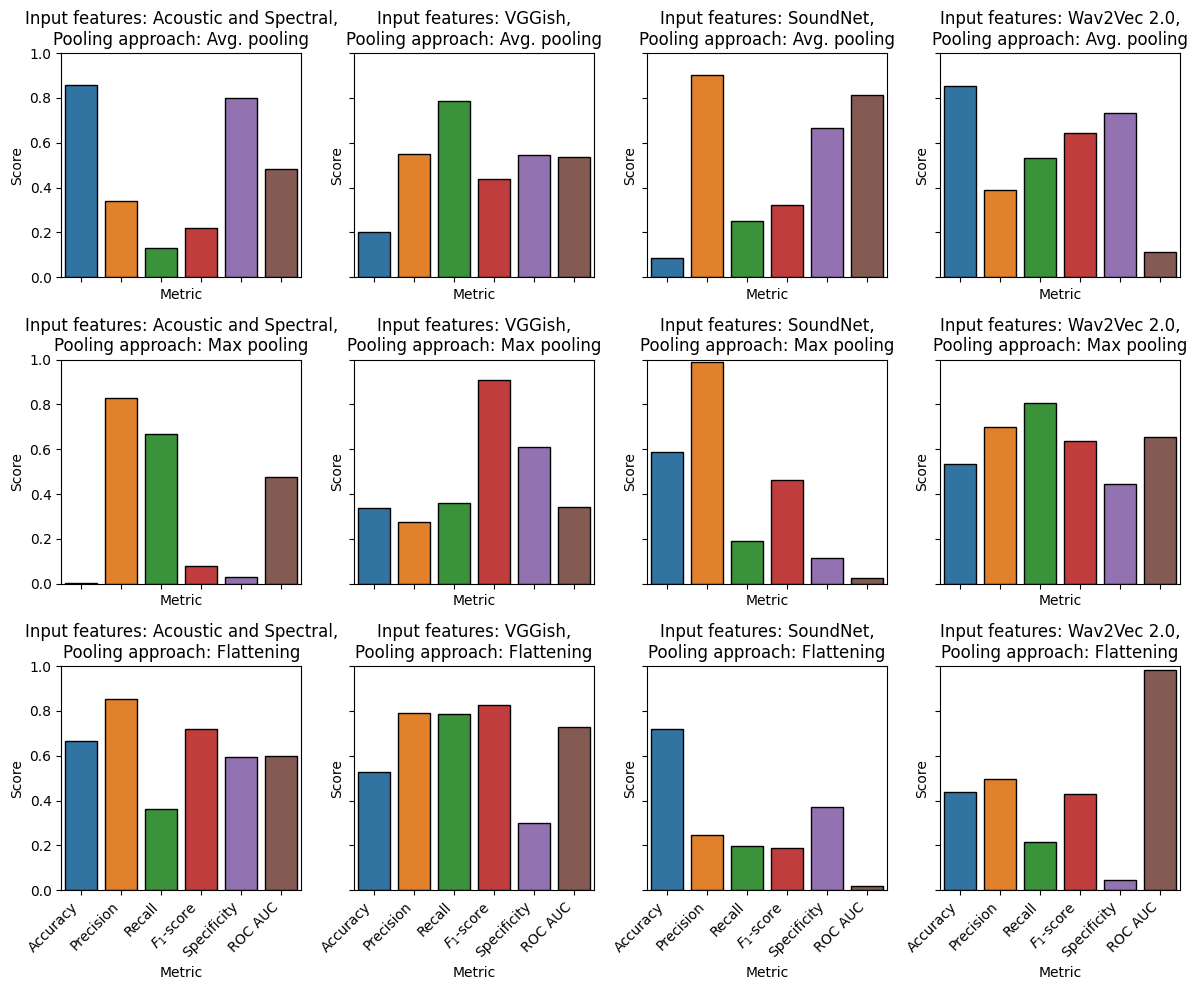

In [65]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        sns.barplot(
            data=df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling)],
            x='Metric',
            y='Value',
            ax=axes[i][j],
            linewidth=1.,
            edgecolor='0',
            order=list(METRICS)
        )
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        axes[i][j].set_xlabel('Metric')
        axes[i][j].set_ylabel('Score')
        axes[i][j].set_ylim(0.0, 1.0)
        # axes[i][j].grid()
        axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [66]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_cls_results.pdf'))

#### ROC curve

In [87]:
df = df_hi_to_en[
    (df_hi_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_hi_to_en['Data set'] == DATA_MAPPING['src']) & (df_hi_to_en['Metric'].isin(ROC))
]
df.sample(10)

,Input features,Pooling approach,Domain adaptation,Data set,Metric,Value
175,VGGish,Avg. pooling,None,Source data (test split),False positives rate,"[0.5383279262763604, 0.17121315299487194, 0.32..."
120,Acoustic and Spectral,Flattening,None,Source data (test split),True postives rate,"[0.9416465707506744, 0.8972443620341845, 0.322..."
569,Wav2Vec 2.0,Max pooling,None,Source data (test split),Threshold (from ROC curve),"[0.0904476087978241, 0.28249870876060246, 0.15..."
343,SoundNet,Avg. pooling,None,Source data (test split),False positives rate,"[0.5689736881000864, 0.19808823417019406, 0.17..."
512,Wav2Vec 2.0,Avg. pooling,None,Source data (test split),True postives rate,"[0.07259062186429621, 0.09559210993889333, 0.1..."
399,SoundNet,Max pooling,None,Source data (test split),False positives rate,"[0.18783419761845932, 0.7562312784238295, 0.96..."
456,SoundNet,Flattening,None,Source data (test split),True postives rate,"[0.9388524591496124, 0.8299456532589105, 0.885..."
624,Wav2Vec 2.0,Flattening,None,Source data (test split),True postives rate,"[0.16141250270132024, 0.16403023856783738, 0.2..."
119,Acoustic and Spectral,Flattening,None,Source data (test split),False positives rate,"[0.6688107617822278, 0.8286881786396217, 0.117..."
8,Acoustic and Spectral,Avg. pooling,None,Source data (test split),True postives rate,"[0.8584545692540013, 0.243385705379214, 0.1247..."


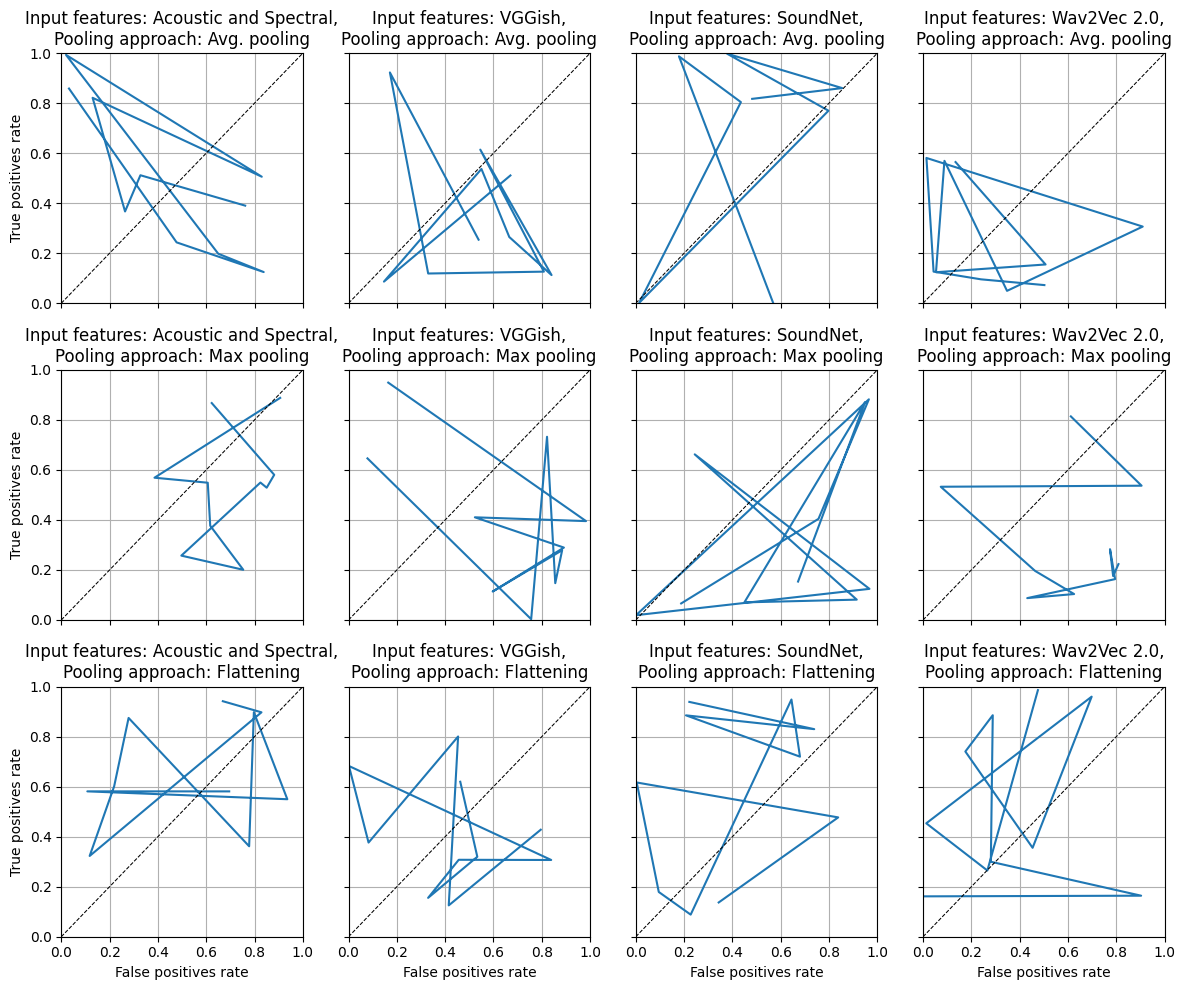

In [95]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'False positives rate')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'True postives rate')]['Value'].values[0]
        axes[i][j].plot(x, y)
        axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('False positives rate')
        if j == 0:
            axes[i][j].set_ylabel('True positives rate')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()
        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_roc_curve.pdf'))

#### Precision-recall curve

In [97]:
df = df_hi_to_en[
    (df_hi_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_hi_to_en['Data set'] == DATA_MAPPING['src']) & (df_hi_to_en['Metric'].isin(PRC_REC))
]
df.sample(10)

,Input features,Pooling approach,Domain adaptation,Data set,Metric,Value
516,Wav2Vec 2.0,Avg. pooling,None,Source data (test split),Threshold (from precision-recall curve),"[0.45621208907915767, 0.33792683188034767, 0.6..."
123,Acoustic and Spectral,Flattening,None,Source data (test split),Recall score,"[0.7427016382746776, 0.6507205099357959, 0.431..."
348,SoundNet,Avg. pooling,None,Source data (test split),Threshold (from precision-recall curve),"[0.411010096130919, 0.09597177795118594, 0.579..."
514,Wav2Vec 2.0,Avg. pooling,None,Source data (test split),Precision score,"[0.007450578434183064, 0.39204513232779825, 0...."
515,Wav2Vec 2.0,Avg. pooling,None,Source data (test split),Recall score,"[0.7591527568139083, 0.8816224417078561, 0.303..."
180,VGGish,Avg. pooling,None,Source data (test split),Threshold (from precision-recall curve),"[0.8281929873262445, 0.08755083535524433, 0.11..."
572,Wav2Vec 2.0,Max pooling,None,Source data (test split),Threshold (from precision-recall curve),"[0.18445965282290055, 0.002325757941810891, 0...."
571,Wav2Vec 2.0,Max pooling,None,Source data (test split),Recall score,"[0.8738442651013978, 0.3760945499757484, 0.653..."
236,VGGish,Max pooling,None,Source data (test split),Threshold (from precision-recall curve),"[0.37548465868310665, 0.3946204053566661, 0.33..."
403,SoundNet,Max pooling,None,Source data (test split),Recall score,"[0.8164875802260365, 0.368533615677051, 0.0562..."


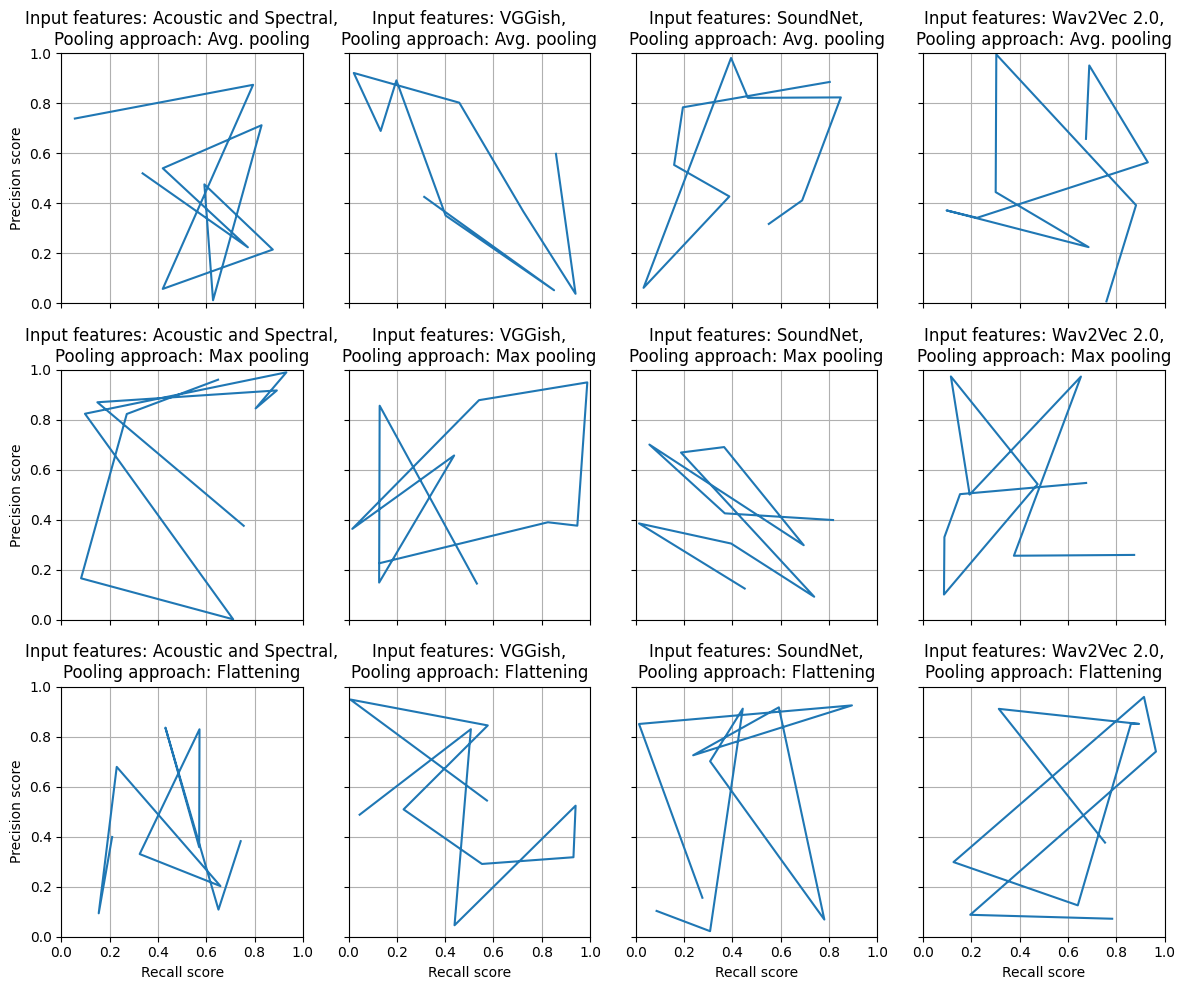

In [98]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Recall score')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Precision score')]['Value'].values[0]
        axes[i][j].plot(x, y)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Recall score')
        if j == 0:
            axes[i][j].set_ylabel('Precision score')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()
        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_pr_curve.pdf'))

#### Confusion matrix

In [202]:
df = df_hi_to_en[
    (df_hi_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_hi_to_en['Data set'] == DATA_MAPPING['src']) & (df_hi_to_en['Metric'].isin(CONF_MAT))
]
df.sample(10)

,Input features,Pooling approach,Domain adaptation,Data set,Metric,Value
69,Acoustic and Spectral,Max pooling,None,Source data (test split),Confusion matrix,"[[18, 6], [5, 8]]"
517,Wav2Vec 2.0,Avg. pooling,None,Source data (test split),Confusion matrix,"[[14, 7], [15, 0]]"
573,Wav2Vec 2.0,Max pooling,None,Source data (test split),Confusion matrix,"[[16, 3], [2, 19]]"
125,Acoustic and Spectral,Flattening,None,Source data (test split),Confusion matrix,"[[1, 17], [3, 14]]"
237,VGGish,Max pooling,None,Source data (test split),Confusion matrix,"[[2, 13], [5, 10]]"
461,SoundNet,Flattening,None,Source data (test split),Confusion matrix,"[[10, 8], [5, 7]]"
629,Wav2Vec 2.0,Flattening,None,Source data (test split),Confusion matrix,"[[16, 3], [18, 9]]"
349,SoundNet,Avg. pooling,None,Source data (test split),Confusion matrix,"[[15, 15], [19, 4]]"
293,VGGish,Flattening,None,Source data (test split),Confusion matrix,"[[1, 18], [0, 5]]"
13,Acoustic and Spectral,Avg. pooling,None,Source data (test split),Confusion matrix,"[[11, 16], [8, 17]]"


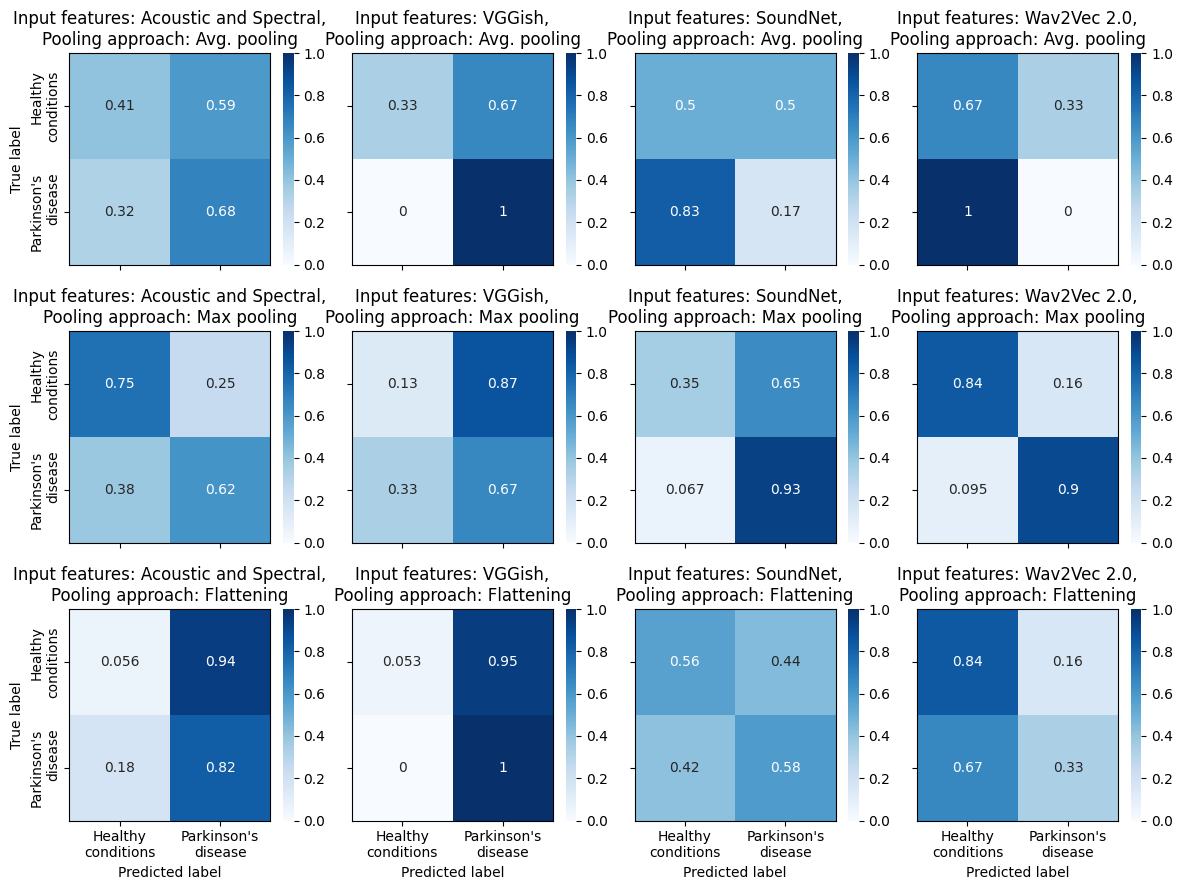

In [240]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [178]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_cm.pdf'))

## Transferring from Hindi to English